In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymaster as nmt
import healpy as hp

## The problem

### Filtering
The general problem is as follows: we have an observed map $\tilde{\bf m}$ which is linearly related to the true underlying map via a linear operator ${\sf F}$:
$$
\tilde{m}_p = \sum_{p'} F_{pp'}\,m_{p'}
$$
The filter ${\sf F}$ encodes TOD-level and map-level filtering, as well as any additional post-processing linear operations done on the map (e.g. Smith-like or matrix-based purification). Note that the equation above is a generalisation of masking, where ${\sf F}$ is just diagonal ($F_{pp'}=w_p\delta_{pp'}$, where ${\bf w}$ is the mask).

To simplify the notation, for now, we're considering ${\bf m}$ to be a scalar field (e.g. $T$).

### Bandpower window functions
Consider now computing the power spectrum of $\tilde{m}_p$ naively, using an estimator of the form:
$$
\tilde{C}_b = \sum_{\ell\in b} f_{\ell b}\frac{1}{2\ell+1}\sum_m |\tilde{m}_{\ell m}|^2,
$$
where $\tilde{m}_{\ell m}$ are the harmonic coefficients of ${\bf m}$, and $f_{\ell b}$ are a set of coefficients defining the weights with which individual multipoles $\ell$ are combined into bandpower $b$. It is easy to show that the pseudo-bandpowers $\tilde{C}_b$ are, in general, linearly related to the true $C_\ell$
$$
\langle \tilde{C}_b\rangle=\sum_{\ell} B_{b\ell} C_\ell,
$$
where $B_{b\ell}$ are the **bandpower window functions**, which depend solely on ${\sf F}$, and not on the true input power spectrum.

### $B_{b\ell}$ from simulations
In the simple case where ${\bf F}$ is diagonal (i.e. it only involves masking), the bandpower window functions can be calculated with the usual pseudo-$C_\ell$ method (e.g. with NaMaster). In the general case, however, although an analytical expression for $B_{b\ell}$ can be written down, it is prohibitively expensive to compute. An alternative is to use "$\delta$ simulations". Consider generating maps $m^{\ell_0}$ that satisfy $\langle |m^{\ell_0}_{\ell m}|^2\rangle=\delta_{\ell\ell_0}$, i.e. maps in which a single multipole $\ell_0$ is excited. If we subject those maps to the same filtering operator ${\sf F}$, and compute the bandpowers of the resulting filtered maps, the result is:
$$
\tilde{C}^{\ell_0}_b\equiv\left\langle \sum_{\ell\in b} f_{\ell b}\frac{1}{2\ell+1}\sum_m |\tilde{m}^{\ell_0}_{\ell m}|^2\right\rangle=B_{b\ell_0}.
$$
I.e. each ensemble of such maps gives us one column of the bandpower window function.

### What we're trying to answer here
If we are to resort to this methodology to estimate the impact of filtering on the power spectrum, we need to answer two main questions:
- How many simulations do we need in order to obtain sufficiently accurate bandpower window functions?
- Is it reasonable to expect that we can actually filter (i.e. "observe") so many of these simulations?

We want to answer these questions for the analysis parameters we expect to use with the real data:
- Maps with $N_{\rm side}=256$.
- Bandpowers covering the range $\ell<300$ with widths $\Delta\ell\sim10$ (we can probably do $\Delta\ell\sim20$, but it'd be good to check how much sensitivity to $r$ we lose - if any).
- Spin-2, so the power spectra involve $EE$, $EB$, $BE$, and $BB$, and the bandpower window functions can mix not only the different $\ell$s, but also the different polarization combinations.

To answer the first question, we can assume a simple diagonal filter matrix (i.e. a mask), for which we know how to calculate the $B_{b\ell}$s analytically. Below I show how to do this for a spin-0 map at $N_{\rm side}=64$. This needs generalising to the above.

### 1. Setup
- Read mask.
- Write a function that generates and filters random maps.
- Write another function that takes one of these maps and computes bandpowers.

In [2]:
# Read mask
nside = 64
msk = hp.read_map("../SensitivityCheck/data/mask_apodized.fits")
msk = hp.ud_grade(msk, nside_out=nside)

# Generate NaMaster bins
b = nmt.NmtBin(nside, nlb=10)
n_bpw = b.get_n_bands()

def gen_filsim(cl):
    # Generate filtered sim
    # Note: we're using synfast, but it's not clear that Gaussian random fields
    #    are the optimal choice to obtain converged bandpower windows with as
    #    few sims as possible.
    m = hp.synfast(cl, nside)
    return msk*m
    
def get_bandpower(m, iter=0):
    cl = hp.anafast(m, iter=iter)
    cb = b.bin_cell(cl)
    return cb

### 2. Compute exact bandpowers
Now let's use NaMaster to compute the exact bandpower windows, and plot them

In [3]:
f = nmt.NmtField(msk, None, spin=0)
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f, f, b)

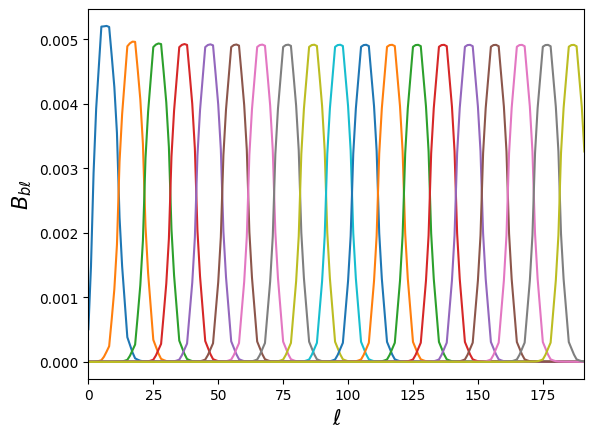

In [4]:
# Note that, although there is a `get_bandpower_windows` method,
# we can't use it in this case, since these are the bandpower
# windows of the decoupled-C_ell (in the NaMaster parlance),
# and here we're doing this for the coupled C_ells. Instead,
# we get the mode-coupling matrix and then bin one of its indices.
mcm = w.get_coupling_matrix()

bpw_true = np.array([b.bin_cell(m) for m in mcm.T]).T

for bpw in bpw_true:
    plt.plot(bpw)
plt.xlim([0, 3*nside-1])
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$B_{b\ell}$', fontsize=15);

### 3. Compute bandpower windows through simulations
We will try to compute the bandpower windows using only 10 simulations per multipole. I.e. this means $10\times3 N_{\rm side}\sim2000$ sims in our case!

In [5]:
nsims_per_ell = 10
ells = np.arange(3*nside)

# Loop through multipoles and sims
cb_sims = np.zeros([3*nside, nsims_per_ell, n_bpw])
for ell in ells:
    cl = np.zeros(3*nside)
    cl[ell] = 1
    print(f"Doing ell={ell}")
    for isim in range(nsims_per_ell):
        m_tilde = gen_filsim(cl)
        cb_sims[ell, isim, :] = get_bandpower(m_tilde)

# Average over sims to obtain bandpower windows
bpw_num = np.mean(cb_sims, axis=1).T

Doing ell=0
Doing ell=1
Doing ell=2
Doing ell=3
Doing ell=4
Doing ell=5
Doing ell=6
Doing ell=7
Doing ell=8
Doing ell=9
Doing ell=10
Doing ell=11
Doing ell=12
Doing ell=13
Doing ell=14
Doing ell=15
Doing ell=16
Doing ell=17
Doing ell=18
Doing ell=19
Doing ell=20
Doing ell=21
Doing ell=22
Doing ell=23
Doing ell=24
Doing ell=25
Doing ell=26
Doing ell=27
Doing ell=28
Doing ell=29
Doing ell=30
Doing ell=31
Doing ell=32
Doing ell=33
Doing ell=34
Doing ell=35
Doing ell=36
Doing ell=37
Doing ell=38
Doing ell=39
Doing ell=40
Doing ell=41
Doing ell=42
Doing ell=43
Doing ell=44
Doing ell=45
Doing ell=46
Doing ell=47
Doing ell=48
Doing ell=49
Doing ell=50
Doing ell=51
Doing ell=52
Doing ell=53
Doing ell=54
Doing ell=55
Doing ell=56
Doing ell=57
Doing ell=58
Doing ell=59
Doing ell=60
Doing ell=61
Doing ell=62
Doing ell=63
Doing ell=64
Doing ell=65
Doing ell=66
Doing ell=67
Doing ell=68
Doing ell=69
Doing ell=70
Doing ell=71
Doing ell=72
Doing ell=73
Doing ell=74
Doing ell=75
Doing ell=76
Doing ell

### 4 Compare numerical and true estimates
Now we compare the numerical and true bandpower windows. Here we just plot them together and perhaps worry a bit. A better test would be to convolve the target power spectrum (i.e. the expected CMB $E/B$ power spectra) with both sets of window functions, and compare the result with the expected error bars for each bandpower. An even better test would be to propagate into constraints on $r$ (this is actually not that hard if you've already got the $C_\ell$s and their error bars).

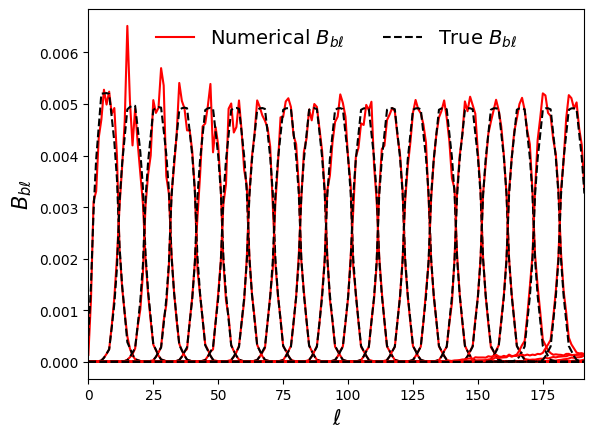

In [6]:
for bpw_t, bpw_n in zip(bpw_true, bpw_num):
    plt.plot(bpw_n, 'r-')
    plt.plot(bpw_t, 'k--')
plt.plot([-1], [0], 'r-', label='Numerical $B_{b\ell}$')
plt.plot([-1], [0], 'k--', label='True $B_{b\ell}$')
plt.xlim([0, 3*nside-1])
plt.xlabel('$\ell$', fontsize=15)
plt.ylabel('$B_{b\ell}$', fontsize=15)
plt.legend(ncol=2, loc='upper center', fontsize=14, frameon=False);

Uuuh, notice the crap in the last few bandpowers? This is all HEALPix rubbish for $\ell>2 N_{\rm side}$, so just a reminder that we need to throw that away!